In [107]:
import numpy as np
import pandas as pd
import math
import time
import random
import matplotlib.pyplot as plt
from itertools import combinations 
import matplotlib.pyplot as plt
import multiprocessing as mp
import string
from sklearn import tree, preprocessing

# **Q1**

In [108]:
def entropy(data, main_data):  
    
    dcol=main_data.columns
    data_target=data[data.columns[-1]]
    main_data_target=main_data[main_data.columns[-1]]
    r=len(data_target)
    main_data_target_unique=pd.unique(main_data_target)
    l=len(main_data_target_unique)
    
    ans=0
    
    for i in range (0,l):
        g= data_target[data_target==main_data_target_unique[i]]
        row=len(g)
        
        if row==0:
            e=0
        
        else:
            e=-(row/r)* math.log((row/r),2)
        
        ans=ans+e
    return ans


In [109]:
def best_split(data, main_data):
    
    r,_=data.shape
    dcol=data.columns
    bestsplit_eachcol=[]
    max_infogain_eachcol=[]
    main_data_target_unique=pd.unique(main_data[dcol[-1]])
    array=[]
    
    for i in range (0,len(main_data_target_unique)):
        rows,_=data[data[dcol[-1]]==main_data_target_unique[i]].shape
        array.append(rows)
    
    zeros=0
    
    for i in range (0,len(array)):
        if array[i]==0:
            zeros=zeros+1
    
    if zeros!=len(array)-1:
        
        for i in range (0, len(dcol)-1):
            data_coli=data.loc[:,[dcol[i],dcol[-1]]]
            data_coli=data_coli.sort_values(dcol[i],ascending=True)
            coli_unique=pd.unique(data_coli[dcol[i]])
            coli_uni_avg=(coli_unique[1:]+coli_unique[:-1])/2
            info_gain=[0]
        
            
            for j in range (0, len(coli_uni_avg)):
                d1=data_coli[data_coli[dcol[i]]<=coli_uni_avg[j]]
                d2=data_coli[data_coli[dcol[i]]>coli_uni_avg[j]]
                r1,_=d1.shape
                r2,_=d2.shape
                infg=entropy(data,main_data)-(r1/r)*entropy(d1,main_data)-(r2/r)*entropy(d2,main_data)
                info_gain.append(infg)
            
            max_infg_index=info_gain.index(max(info_gain))-1
            bestsplit_eachcol.append((dcol[i] ,coli_uni_avg[max_infg_index],array))
            max_infogain_eachcol.append(info_gain[max_infg_index])
    
        max_ind=max_infogain_eachcol.index(max(max_infogain_eachcol))
        return bestsplit_eachcol[max_ind]
    
    else:
        bestsplit_eachcol.append(('no_split',0,array))
        return bestsplit_eachcol[0]

In [110]:
def tree_learning(data, depth, main_data):
        bs=best_split(data, main_data)
        t=dict()
        if depth>0 and bs[0]!='no_split':
            depth=depth-1
            ln=data[data[bs[0]]<=bs[1]]
            rn=data[data[bs[0]]>bs[1]]
            t['l']=tree_learning(ln, depth, main_data)
            t['r']=tree_learning(rn, depth, main_data)
            return [bs,t]
        else:
            return [(['no_split'],0,bs[2]),{}]

In [111]:
def divide_data(data,train_size):
    r=len(data)
    dr=int(r*(train_size))
    train_data=data[:dr]
    test_data=data[dr:]
    return (train_data,test_data)

In [112]:
def RandomForests(train_data, train_size, estimator_number, depth, feature_choices):
    dcol=train_data.columns
    target=dcol[-1]
    shuffled_train_data=train_data.sample(frac=1).reset_index(drop=True)

    feature_combinations=list(combinations(train_data.columns[:-1],feature_choices))

    
    forest=dict()
    for i in range(0,estimator_number):
        k=i
        if i>(len(feature_combinations)-1):
            j=int(i/(len(feature_combinations)-1))
            i=i-j*(len(feature_combinations)-1)
        
        sub_feature_data= shuffled_train_data.loc[:,[feature_combinations[i][0],feature_combinations[i][1],target]]
        #print(sub_feature_data)
        shuffled_sub_feature_data=sub_feature_data.sample(frac=1).reset_index(drop=True)
        
        train_data_i ,_=divide_data(shuffled_sub_feature_data,train_size)
        model_i=tree_learning(train_data_i, depth, train_data)
        
        forest[str(k)]=model_i
    
    return forest
        
            
        

In [113]:
random.seed(123)
output = mp.Queue()

def Random_Forest_parallel(train_data, train_size, depth, feature_choices):
    
    dcol=train_data.columns
    target=dcol[-1]
    
    feature_combinations=list(combinations(train_data.columns[:-1],feature_choices))
    features=random.choice(feature_combinations)
    
    shuffled_train_data=train_data.sample(frac=1).reset_index(drop=True)
    sub_feature_data= shuffled_train_data.loc[:,[features[0],features[1],target]]
    
    shuffled_sub_feature_data=sub_feature_data.sample(frac=1).reset_index(drop=True)
        
    train_data_i ,_=divide_data(shuffled_sub_feature_data,train_size)
    model_i=tree_learning(train_data_i, depth, train_data)
    
    output.put(model_i)

In [114]:
data1=pd.read_csv('iris_dataset.csv')

iris=data1.loc[:,['sepal length','sepal width','petal length','petal width','iris']]
iris.columns=['sepal_length','sepal_width','petal_length','petal_width','iris']

iris=iris.sample(frac=1).reset_index(drop=True)
train_data,test_data=divide_data(iris,0.7)

In [168]:
train_data_list=[train_data]*20
processes = [mp.Process(target=Random_Forest_parallel, args=(x, 0.7,2,2)) for x in train_data_list]

# Run processes
for p in processes:
    p.start()

# Exit the completed processes
for p in processes:
    p.join()

start_time=time.time()
results = [output.get() for p in processes]
stop_time=time.time()
time_difference = stop_time-start_time

print('time taken for multiprocessing Random Forests', time_difference,'sec')

time taken for multiprocessing Random Forests 0.0008351802825927734 sec


In [116]:
start_time=time.time()
rf=RandomForests(train_data,0.7,20,2,2)
stop_time=time.time()
time_difference = stop_time-start_time

print('time taken for serial-processing Random Forests', time_difference,'sec')

time taken for serial-processing Random Forests 10.446208000183105 sec


Therefore, as we increase parallelization, the computation time or the practical time complexity decreases to a great extent when compared to that of the serial processing 

In [117]:
def testing(test_row,model):
    a=model[0]
    dic=model[1]
    if a[0]== ['no_split']:
        return a[2].index(max(a[2]))
    else:
        if test_row[a[0]]<a[1]:
            return testing(test_row,dic['l'])
        else :
            return testing(test_row,dic['r'])

def prediction(test_data,model):
    r=len(test_data)
    predictions=[]
    for i in range (0,r):
        test_row=test_data.iloc[i]       
        pred=testing(test_row,model)
        predictions.append(pred)
    return predictions

def accuracy (test_data,predictions,train_data):
    c=0
    ic=0
    dcol=test_data.columns
    r,_=test_data.shape
    gt=test_data[test_data.columns[-1]]
    #analog=['Iris-setosa','Iris-versicolor','Iris-virginica']
    analog=pd.unique(train_data['iris'])
    for i in range (0,r):
        if analog[int(predictions[i])]==gt.iloc[i]:
            c=c+1
        else:
            ic=ic+1
    accuracy=(c/r)*100
    return accuracy 

In [122]:
def random_forest_testing(forest,test_data,train_data):
    accuracy_each_model=[]
    for i in range (0,len(forest)):
        #pred_each_model.append(prediction(test_data,forest[str(i)]))
        predictions_i = prediction(test_data,forest[str(i)])
        accuracy_each_model.append(accuracy(test_data,predictions_i,train_data))
    print('accuracies of each tree',accuracy_each_model)
    sum_accuracy = sum(accuracy_each_model)
    avg_accuracy=sum_accuracy/len(accuracy_each_model)
    w='avg_accuracy'
    return  w,avg_accuracy
    #print(len(pred_each_model))
    #sum_predictions=np.array(list(map(sum,pred_each_model)))
    #avg_predictions=sum_predictions/len(forest)
    #print(avg_predictions)
    #rounded_predictions=np.around(avg_predictions)
    #rounded_predictions.tolist()
    #print(rounded_predictions)
    #return accuracy (test_data, rounded_predictions, train_data)
    
    

In [123]:
random_forest_testing(rf, test_data, train_data)

accuracies of each tree [71.11111111111111, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 84.44444444444444, 93.33333333333333, 93.33333333333333, 95.55555555555556, 68.88888888888889, 93.33333333333333, 93.33333333333333, 84.44444444444444, 95.55555555555556, 73.33333333333333, 93.33333333333333, 95.55555555555556, 84.44444444444444, 93.33333333333333]


('avg_accuracy', 88.99999999999999)

# **Q4**

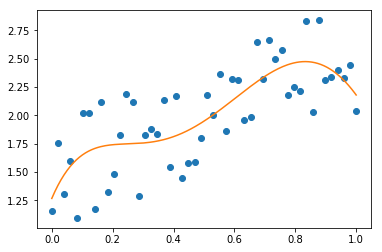

In [160]:
points=50
m=1
c=1
degree_fit=5

x=np.linspace(0,1,points)
np.random.seed(12)
random_noise=np.random.rand(points)
y=m*x+c+random_noise

p = np.poly1d(np.polyfit(x, y, degree_fit))

t = np.linspace(0, 1, 200)
plt.plot(x, y, 'o', t, p(t), '-')
plt.show()

    

In [161]:
data_points=[]
    
for i in range (0, len(x)):
    data_points.append((x[i],y[i]))
data_points=np.array(data_points)
np.random.shuffle(data_points)
bagging_train_data,bagging_test_data = divide_data(data_points,0.8)
np.random.shuffle(bagging_train_data)


In [162]:
def bagging(main_data, train_size, estimator_number, degree_fit):
    bagging_train_data=main_data
    random.shuffle(bagging_train_data)
    independent_models=dict()
    
    for j in range (0,estimator_number):
        
        random.shuffle(bagging_train_data)
        
        train_data_j,_ = divide_data(bagging_train_data, train_size)
        
        train_data_j_input=np.zeros((len(train_data_j),))
        train_data_j_output=np.zeros((len(train_data_j),))
        
        for t in range (0,len(train_data_j)):
            train_data_j_input[t] = train_data_j[t][0]
            train_data_j_output[t] = train_data_j[t][1]
        
        #print(train_data_j_input, train_data_j_output)
        modelj = np.poly1d(np.polyfit(train_data_j_input, train_data_j_output, degree_fit)) 
        
        independent_models[str(j)]= modelj
            
    return independent_models
    
    

In [163]:
bagging_models=bagging(bagging_train_data,0.8,100,5)


/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly cond

In [164]:
def bagging_predictions( independent_models, bagging_test_data):
    all_pred=[]
    t=np.linspace(0,1,200)
    for i in range (0, len(independent_models)):
        p= independent_models[str(i)]
        all_pred.append(p(t))
    
    sum_all_pred= list(map(sum,zip(*all_pred)))
    sum_all_pred=np.array(sum_all_pred)
    
    avg_all_pred=sum_all_pred/len(independent_models)
    avg_all_pred.tolist()
    return avg_all_pred
        

In [165]:
h=bagging_predictions(bagging_models, bagging_test_data )

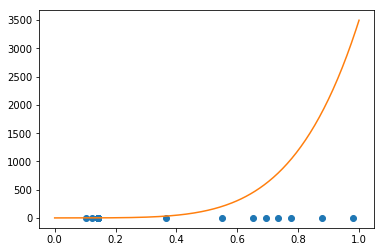

In [166]:
test_input=np.zeros((len(data_points),))
test_target=np.zeros((len(data_points),))

for i in range (0,len(data_points)):
    test_input[i]=data_points[i][0]
    test_target[i]=data_points[i][1]
    
plt.plot(test_input, test_target, 'o', t, h, '-')
plt.show()

In [140]:
bagging_models_1=bagging(bagging_train_data,0.8,100,20)
h1 = bagging_predictions(bagging_models_1, bagging_test_data )

/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/chennuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly cond

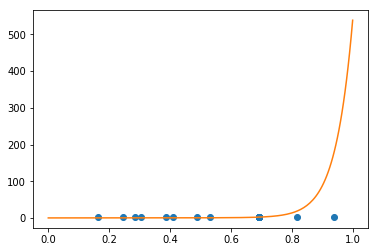

In [143]:
plt.plot(test_input, test_target, 'o', t, h1, '-')
plt.show()

As we change the train data and test data for the above algorithm the 5 degree fit changes drastically. according to me the reason behind this could be that the number of points available for train and test is really low i.e, 50 points.As the data points increase the curve starts getting stabilized. 

Moreover, if we increase the fit from 5 to 20 the accuracy of bagging increases to a great extent.

as it is bagging, it is not prone to high variance.

# **Q5**

In [144]:
def random_number_selection(N):
    dividend=time.time()*1000000
    divisor=N
    
    remainder=dividend%divisor
    if remainder == 0:
        return divisor%divisor
    else:
        return int(remainder)

In [145]:
random_number_selection(1000)

554

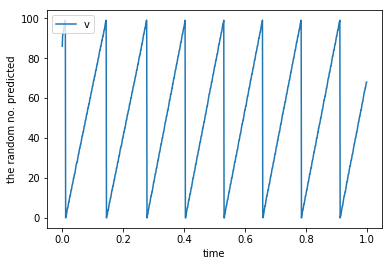

In [146]:
readings = np.zeros((1000,))
x=np.linspace(0,1,1000)
for i in range (0,1000):
    readings[i] = random_number_selection(100)

plt.plot(x,readings)
plt.ylabel('the random no. predicted')
plt.xlabel('time')
plt.legend('variation in predicted values')

yes , we do get a roughly uniform distribution

# **Q3** 

In [147]:
# re-encoding:
adaboost_dataset=iris
adaboost_dataset.iloc[np.where(iris['iris']!='Iris-virginica')[0],-1]='not_virginica'
adaboost_data=adaboost_dataset.loc[:,['sepal_length','petal_width','iris']]
adaboost_data

,sepal_length,petal_width,iris
0,6.2,1.3,not_virginica
1,7.2,1.6,Iris-virginica
2,5.0,0.2,not_virginica
3,6.3,2.5,Iris-virginica
4,6.5,1.5,not_virginica
5,5.1,0.3,not_virginica
6,5.0,0.2,not_virginica
7,6.2,1.8,Iris-virginica
8,6.9,2.3,Iris-virginica
9,6.9,2.1,Iris-virginica


In [148]:
def weights_update( initial_weights, terror_list, stage):
    modified_weights=[]
    for i in range (0,len(initial_weights)):
        modified_weights.append(initial_weights[i]*math.exp(stage*terror_list[i]))
    return modified_weights    

In [149]:
def adaboost(dataset, iteration_number):
    decision_trees=dict()
    all_indexes= list(range(len(dataset)))
    
    weights=[1/len(dataset)]*len(dataset)
    weights=np.array(weights)
    dataset_target_values=pd.unique(dataset['iris'])
    
    for i in range (0,iteration_number):
        data_i_indexes=[]
        terror_list=[]
        error = 0
        
        for j in range (0,int(len(dataset))):
            indexj = np.random.choice(all_indexes,p=weights)
            data_i_indexes.append(indexj)
        
        train_data_i = dataset.loc[data_i_indexes,dataset.columns].reset_index(drop=True)
        
        model_i = tree_learning(train_data_i, 1, dataset)
        
        predictions = prediction(dataset,model_i)
        
        accuracy_model_i = accuracy(dataset,predictions,train_data_i)
        
        decision_trees[str(i)] = (model_i , accuracy_model_i, weights)
        
        for k in range (0,len(dataset)):
            if dataset['iris'][k] == dataset_target_values[predictions[k]]:
                terror_list.append(0)
            else:
                terror_list.append(1)
        
        #print(len(terror_list))
        #print(len(weights))
        for g in range (0,len(dataset)):
            error = error + (weights[g]*terror_list[g])
        
        net_error=error/sum(weights)
        
        stage= math.log((1-net_error)/net_error)
        #print(stage)
        #print(weights)
        weights= weights_update(weights,terror_list,stage)
        #print(weights)
        s= sum(weights)
        weights = np.array(weights)
        weights = weights/s
    
    return decision_trees
        

In [151]:
adaboost_trees = adaboost(adaboost_data,10)
adaboost_trees

{'0': ([('petal_width', 1.75, [98, 52]),
   {'l': [(['no_split'], 0, [97, 3]), {}],
    'r': [(['no_split'], 0, [1, 49]), {}]}],
  96.0,
  array([0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
         0.00666667, 0.00666667, 0.

Text(0.5, 1.0, '85.33333333333334')

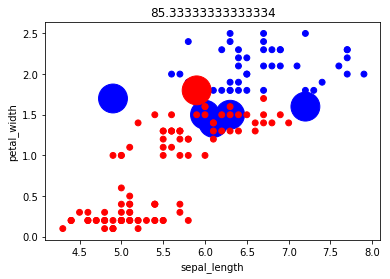

In [157]:
virginica_indexes = np.where(adaboost_data['iris'] =='Iris-virginica')[0]
not_virginica_indexes = np.where(adaboost_data['iris'] !='Iris-virginica')[0]

sepal_length_data= adaboost_data['sepal_length']
petal_width_data= adaboost_data['petal_width']

virginica_points_x=[]
virginica_points_y=[]
not_virginica_points_x=[]
not_virginica_points_y=[]


for i in range(0, len(virginica_indexes)):
    virginica_points_x.append(sepal_length_data[virginica_indexes[i]])
    virginica_points_y.append(petal_width_data[virginica_indexes[i]])

for i in range(0, len(not_virginica_indexes)):
    not_virginica_points_x.append(sepal_length_data[not_virginica_indexes[i]])
    not_virginica_points_y.append(petal_width_data[not_virginica_indexes[i]])
    
def weights_division(weights,virginica_indexes,not_virginica_indexes):
    virginica_weights=[]
    not_virginica_weights=[]
    for i in range (0,len(virginica_indexes)):
        virginica_weights.append(weights[virginica_indexes[i]])
    
    for i in range (0,len(not_virginica_indexes)):
        not_virginica_weights.append(weights[not_virginica_indexes[i]])
    return (virginica_weights, not_virginica_weights)
    
ITERATION_NUMBER=1  ## please change the iteration number for the corresponding iteration graph  

iteration_weights=adaboost_trees[str(ITERATION_NUMBER)][2]

virginica_weights, not_virginica_weights = weights_division(iteration_weights,virginica_indexes,not_virginica_indexes)

virginica_weights=np.array(virginica_weights)
not_virginica_weights=np.array(not_virginica_weights)


plt.scatter(virginica_points_x, virginica_points_y,virginica_weights*10000, c='b')
plt.scatter(not_virginica_points_x,not_virginica_points_y,not_virginica_weights*10000,c='r')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.title(str(adaboost_trees[str(ITERATION_NUMBER)][1]))

        


NOTE: please change ITERATION_NUMBER in the above cell so as to obtain the graph of the iteration 

In [153]:
noise_data = np.copy(adaboost_data)
noise = np.array([[7.5,2.5,'not Iris-virginica'],[7.8,2.4,'not Iris-virginica'],[7.6,2.3,'not Iris-virginica'],[7.4,2.6,'not Iris-virginica'],
                 [8.2,2.2,'not Iris-virginica'],[5.2,0.8,'Iris-virginica'],[5,0.3,'Iris-virginica'],[4.4,0.6,'Iris-virginica'],
                 [4.5,0.2,'Iris-virginica'],[4,0.6,'Iris-virginica'],[5.6,0.4,'Iris-virginica']])

In [154]:
noise_data = np.concatenate((noise_data,noise))
noise_data1 = pd.DataFrame(noise_data,index=np.arange(len(noise_data)),columns=["sepal_length","petal_width","iris"])
noise_data1["sepal_length"] = noise_data1["sepal_length"].astype(float)
noise_data1["petal_width"] = noise_data1["petal_width"].astype(float)

In [155]:
adaboost_noise_trees=adaboost(noise_data1,10)

Text(0.5, 1.0, '85.33333333333334')

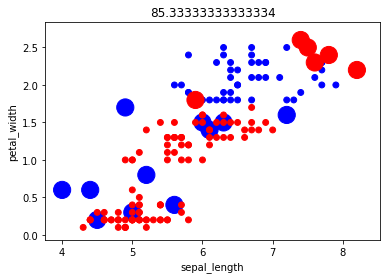

In [156]:
virginica_indexes = np.where(noise_data1['iris'] =='Iris-virginica')[0]
not_virginica_indexes = np.where(noise_data1['iris'] !='Iris-virginica')[0]

sepal_length_data= noise_data1['sepal_length']
petal_width_data= noise_data1['petal_width']

virginica_points_x=[]
virginica_points_y=[]
not_virginica_points_x=[]
not_virginica_points_y=[]


for i in range(0, len(virginica_indexes)):
    virginica_points_x.append(sepal_length_data[virginica_indexes[i]])
    virginica_points_y.append(petal_width_data[virginica_indexes[i]])

for i in range(0, len(not_virginica_indexes)):
    not_virginica_points_x.append(sepal_length_data[not_virginica_indexes[i]])
    not_virginica_points_y.append(petal_width_data[not_virginica_indexes[i]])
    
def weights_division(weights,virginica_indexes,not_virginica_indexes):
    virginica_weights=[]
    not_virginica_weights=[]
    for i in range (0,len(virginica_indexes)):
        virginica_weights.append(weights[virginica_indexes[i]])
    
    for i in range (0,len(not_virginica_indexes)):
        not_virginica_weights.append(weights[not_virginica_indexes[i]])
    return (virginica_weights, not_virginica_weights)
    
ITERATION_NUMBER=1 ## please change the iteration number for the corresponding iteration graph  

iteration_weights=adaboost_noise_trees[str(ITERATION_NUMBER)][2]

virginica_weights, not_virginica_weights = weights_division(iteration_weights,virginica_indexes,not_virginica_indexes)

virginica_weights=np.array(virginica_weights)
not_virginica_weights=np.array(not_virginica_weights)


plt.scatter(virginica_points_x, virginica_points_y,virginica_weights*10000, c='b')
plt.scatter(not_virginica_points_x,not_virginica_points_y,not_virginica_weights*10000,c='r')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.title(str(adaboost_trees[str(ITERATION_NUMBER)][1]))

        


NOTE: please change the iteration number to see the respective iteration graph 

as the noise is added into the data, the weights of the noise increases as the iteration increase as observed in the variation in the graphs 

# **Q2** 

In [62]:
from sklearn.model_selection import train_test_split 

In [63]:
kaggle_train_path='~/Documents/PROJECT/machine learning assignments/assignment 2- Ensemble Methods/TrainAndValid.csv'
kaggle_test_path= '~/Documents/PROJECT/machine learning assignments/assignment 2- Ensemble Methods/Test.csv'

def import_data(path):
    data=pd.read_csv(path)
    return data 

train_valid_data=import_data(kaggle_train_path)
test_data = import_data(kaggle_test_path)

/home/chennuri/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [34]:
from sklearn.ensemble import RandomForestRegressor

In [4]:
print(train_valid_data)

        SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
0       1139246    66000.0     999089     3157         121           3.0   
1       1139248    57000.0     117657       77         121           3.0   
2       1139249    10000.0     434808     7009         121           3.0   
3       1139251    38500.0    1026470      332         121           3.0   
4       1139253    11000.0    1057373    17311         121           3.0   
5       1139255    26500.0    1001274     4605         121           3.0   
6       1139256    21000.0     772701     1937         121           3.0   
7       1139261    27000.0     902002     3539         121           3.0   
8       1139272    21500.0    1036251    36003         121           3.0   
9       1139275    65000.0    1016474     3883         121           3.0   
10      1139278    24000.0    1024998     4605         121           3.0   
11      1139282    22500.0     319906     5255         121           3.0   
12      1139

In [12]:
train_valid_data_features=train_valid_data.loc[:,['ModelID','datasource','YearMade']]
test_data_features=test_data.loc[:,['ModelID','datasource','YearMade']]


In [13]:
train_valid_data_features.dropna(inplace=True)


In [14]:
train_valid_data_target=train_valid_data.loc[:,['SalePrice']]

In [15]:
X_train,X_test,y_train,y_test=train_test_split(train_valid_data_features, train_valid_data_target, test_size=0.25,random_state=4)

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error

In [17]:
model=DecisionTreeRegressor()
model.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [18]:
predict=model.predict(X_test)

In [20]:
error= mean_squared_log_error(y_test,predict)

In [21]:
error

0.09326672082417237

In [27]:
predict_actual= np.log2(model.predict(test_data_features))

In [28]:
predict_df = pd.DataFrame(predict_actual,index=np.arange(len(predict_actual)),columns=["SalePrice"])

final = pd.concat((test_data['SalesID'],predict_df),axis=1)

In [29]:
final.to_csv("results_kaggle.csv",index=False)